In [1]:
# --- Imports
import os, glob, math, time, json, random
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [2]:
# === CONFIG: choose 4 or 7 classes ===
EMO_SET = 7   # change to 4 for the 4-class setup

FOUR  = {"angry","happy","neutral","sad"}
SEVEN = {"angry","happy","neutral","sad","fear","disgust","surprise"}

ACTIVE_EMOS = FOUR if EMO_SET == 4 else SEVEN
SUFFIX = f"{EMO_SET}cls"


In [3]:
# Adjust these only if your paths changed
root = "/projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input"
ravdess = os.path.join(root, "ravdess-emotional-speech-audio", "audio_speech_actors_01-24")
cremad  = os.path.join(root, "cremad", "AudioWAV")
tess    = os.path.join(root, "toronto-emotional-speech-set-tess", "tess toronto emotional speech set data", "TESS Toronto emotional speech set data")
savee   = os.path.join(root, "surrey-audiovisual-expressed-emotion-savee", "ALL")

def list_wavs(root_dir):
    return sorted(glob.glob(os.path.join(root_dir, "**", "*.wav"), recursive=True))

def process_ravdess(root_dir):
    id2emo = {"01":"neutral","02":"neutral","03":"happy","04":"sad","05":"angry","06":"fear","07":"disgust","08":"surprise"}
    paths, emos = [], []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("-")
        if len(parts) >= 3 and parts[2] in id2emo:
            paths.append(p); emos.append(id2emo[parts[2]])
    return pd.DataFrame({"Path": paths, "Emotions": emos})

def process_cremad(root_dir):
    map3 = {"SAD":"sad","ANG":"angry","DIS":"disgust","FEA":"fear","HAP":"happy","NEU":"neutral"}
    paths, emos = [], []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("_")
        if len(parts) >= 3 and parts[2] in map3:
            paths.append(p); emos.append(map3[parts[2]])
    return pd.DataFrame({"Path": paths, "Emotions": emos})

def process_tess(root_dir):
    # e.g., OAF_back_angry.wav
    paths, emos = [], []
    for p in list_wavs(root_dir):
        head = Path(p).stem
        parts = head.split("_")
        if len(parts) >= 3:
            emo = parts[2]
            emo = "surprise" if emo == "ps" else emo
            paths.append(p); emos.append(emo)
    return pd.DataFrame({"Path": paths, "Emotions": emos})

def process_savee(root_dir):
    tag2emo = {"a":"angry","d":"disgust","f":"fear","h":"happy","n":"neutral","sa":"sad","su":"surprise"}
    paths, emos = [], []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("_")
        if len(parts) >= 2:
            tag = parts[1]  # a01, sa01, su01...
            key = "sa" if tag.startswith("sa") else ("su" if tag.startswith("su") else tag[0])
            if key in tag2emo:
                paths.append(p); emos.append(tag2emo[key])
    return pd.DataFrame({"Path": paths, "Emotions": emos})

dfs = []
for name, f in [("RAVDESS", process_ravdess), ("CREMA-D", process_cremad),
                ("TESS", process_tess), ("SAVEE", process_savee)]:
    try:
        df = f(eval(name.lower().replace("-", "").replace(" ", "")))
        print(f"{name:8s}: {len(df):5d} files")
        dfs.append(df)
    except Exception as e:
        print(f"{name}: skipped ({e})")

data_df = pd.concat(dfs, ignore_index=True)
print("Total files:", len(data_df))
data_df.head()


RAVDESS :  2880 files
CREMA-D :  7442 files
TESS    :  5600 files
SAVEE   :   480 files
Total files: 16402


,Path,Emotions
0,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
1,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
2,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
3,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
4,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral


In [4]:
# Keep only the emotions in the chosen set (4 or 7)
mask = data_df["Emotions"].isin(ACTIVE_EMOS)
data_df = data_df[mask].reset_index(drop=True)
print(f"Filtered to {len(ACTIVE_EMOS)} emotions:", data_df["Emotions"].value_counts())


Filtered to 7 emotions: Emotions
neutral     2583
happy       2515
sad         2515
angry       2515
fear        2515
disgust     2515
surprise    1244
Name: count, dtype: int64


In [5]:
SR = 22050
DURATION = 2.5           # seconds (match what you used in MFCC)
HOP_LENGTH = 512
N_MELS = 128

# Compute target frame length for consistent tensors: T ≈ ceil((SR*DURATION)/HOP_LENGTH)
TARGET_FRAMES = int(math.ceil((SR * DURATION) / HOP_LENGTH))
print("TARGET_FRAMES:", TARGET_FRAMES)

def load_wav(path, sr=SR, duration=DURATION, offset=0.0):
    # offset can be >0 (you used ~0.6 in MFCCs), but we'll keep 0 here for full coverage
    y, sr = librosa.load(path, sr=sr, duration=duration, offset=0.0, mono=True)
    return y, sr

def to_mel_db(y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db  # shape: (n_mels, T)

def pad_or_trim(mel_db, target_frames=TARGET_FRAMES):
    m, t = mel_db.shape
    if t == target_frames:
        return mel_db
    if t < target_frames:
        # pad with min value (very quiet background) to avoid mean shift
        pad_width = target_frames - t
        pad_vals = np.full((m, pad_width), mel_db.min(), dtype=mel_db.dtype)
        return np.hstack([mel_db, pad_vals])
    else:
        return mel_db[:, :target_frames]

def per_sample_standardize(x):
    # Standardize per-sample to zero mean, unit variance; guard against tiny std
    mu = x.mean()
    sigma = x.std()
    return (x - mu) / (sigma + 1e-6)


TARGET_FRAMES: 108


In [6]:
from librosa.feature import delta as lib_delta

CACHE_FILE_3C = f"../cached_data/mel3c_data_cache_{SUFFIX}.npz"
SR = 22050
DURATION = 3.0          # a tad more context than 2.5s
HOP_LENGTH = 512
N_MELS = 128
TARGET_FRAMES = int(np.ceil((SR * DURATION) / HOP_LENGTH))
print("TARGET_FRAMES (3c):", TARGET_FRAMES)

def mel_3ch(y, sr=SR):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = pad_or_trim(mel_db, TARGET_FRAMES)
    # deltas (librosa expects (n_mels, T))
    d1 = lib_delta(mel_db, order=1)
    d2 = lib_delta(mel_db, order=2)
    # per-sample standardize each channel
    def stdz(x): 
        m, s = x.mean(), x.std()
        return (x - m) / (s + 1e-6)
    mel_db = stdz(mel_db); d1 = stdz(d1); d2 = stdz(d2)
    # stack to channels-first (C, H, W) where C=3
    arr = np.stack([mel_db, d1, d2], axis=0).astype(np.float32)
    return arr  # (3, 128, T)

if os.path.exists(CACHE_FILE_3C):
    cache = np.load(CACHE_FILE_3C, allow_pickle=True)
    X_mel3 = cache["X"]
    y_labels = cache["y"]
    classes = list(cache["classes"])
    print("Loaded cached (3c):", X_mel3.shape, len(y_labels))
else:
    # (Re)build y_labels/classes from your filtered data_df (ideally 4 emotions)
    le = LabelEncoder()
    y_labels = le.fit_transform(data_df["Emotions"].values)
    classes = list(le.classes_)
    print("Classes:", classes)

    X_list = []
    for i, p in enumerate(data_df["Path"].values):
        if (i+1) % 400 == 0:
            print(f"Processed {i+1}/{len(data_df)}")
        y, _ = load_wav(p, sr=SR, duration=DURATION, offset=0.0)
        X_list.append(mel_3ch(y))
    X_mel3 = np.stack(X_list, axis=0)  # (N, 3, 128, T)
    np.savez_compressed(CACHE_FILE_3C, X=X_mel3, y=y_labels, classes=np.array(classes, dtype=object))
    print("Saved cache:", CACHE_FILE_3C, X_mel3.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_mel3, y_labels, test_size=0.2, random_state=42, shuffle=True, stratify=y_labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=True, stratify=y_train
)

print("Shapes (3c):")
print("Train:", X_train.shape, len(y_train))
print("Val  :", X_val.shape,   len(y_val))
print("Test :", X_test.shape,  len(y_test))


TARGET_FRAMES (3c): 130
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Processed 400/16402
Processed 800/16402
Processed 1200/16402
Processed 1600/16402
Processed 2000/16402
Processed 2400/16402
Processed 2800/16402
Processed 3200/16402
Processed 3600/16402
Processed 4000/16402
Processed 4400/16402
Processed 4800/16402
Processed 5200/16402
Processed 5600/16402
Processed 6000/16402
Processed 6400/16402
Processed 6800/16402
Processed 7200/16402
Processed 7600/16402
Processed 8000/16402
Processed 8400/16402
Processed 8800/16402
Processed 9200/16402
Processed 9600/16402
Processed 10000/16402
Processed 10400/16402
Processed 10800/16402
Processed 11200/16402
Processed 11600/16402
Processed 12000/16402
Processed 12400/16402
Processed 12800/16402
Processed 13200/16402
Processed 13600/16402
Processed 14000/16402
Processed 14400/16402
Processed 14800/16402
Processed 15200/16402
Processed 15600/16402
Processed 16000/16402
Processed 16400/16402
Saved cache: ../cached_

In [7]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

CACHE_FILE_3C = f"../cached_data/mel3c_data_cache_{SUFFIX}.npz"


assert os.path.exists(CACHE_FILE_3C), "Run the 3-channel Mel cache cell first."
cache = np.load(CACHE_FILE_3C, allow_pickle=True)
X_mel3 = cache["X"]              # (N, 3, 128, T)
y_labels = cache["y"]            # (N,)
classes  = list(cache["classes"])# list of class names
print("Loaded:", X_mel3.shape, len(y_labels), classes)

# splits
X_train, X_test, y_train, y_test = train_test_split(
    X_mel3, y_labels, test_size=0.2, random_state=42, shuffle=True, stratify=y_labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=True, stratify=y_train
)
print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)


Loaded: (16402, 3, 128, 130) 16402 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train/Val/Test: (11152, 3, 128, 130) (1969, 3, 128, 130) (3281, 3, 128, 130)


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

# SpecAugment (in-place masks on spectrogram tensors)
def time_mask_(x, max_T_frac=0.12, num=2):
    B, C, F, T = x.shape
    for _ in range(num):
        t = max(1, int(T * random.uniform(0.0, max_T_frac)))
        t0 = random.randint(0, max(1, T - t))
        x[..., t0:t0+t] = 0
    return x

def freq_mask_(x, max_F_frac=0.12, num=2):
    B, C, F, T = x.shape
    for _ in range(num):
        f = max(1, int(F * random.uniform(0.0, max_F_frac)))
        f0 = random.randint(0, max(1, F - f))
        x[..., f0:f0+f, :] = 0
    return x

def mixup(x, y, alpha=0.2, p=0.35):
    if random.random() > p:
        return x, y, 1.0, None
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mixed = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mixed, (y_a, y_b), lam, idx

class Mel3Dataset(Dataset):
    def __init__(self, X, y, train=False):
        self.X, self.y, self.train = X, y, train
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        x = torch.from_numpy(self.X[i])   # (3, 128, T)
        y = torch.tensor(self.y[i], dtype=torch.long)
        return x, y

BATCH_SIZE = 32
train_loader = DataLoader(Mel3Dataset(X_train, y_train, train=True),  batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Mel3Dataset(X_val,   y_val,   train=False), batch_size=128,       shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Mel3Dataset(X_test,  y_test,  train=False), batch_size=128,       shuffle=False, num_workers=2, pin_memory=True)


In [9]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.down  = None
        if stride != 1 or in_ch != out_ch:
            self.down = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down is not None:
            identity = self.down(identity)
        out += identity
        return self.relu(out)

class MelResNet(nn.Module):
    def __init__(self, n_classes, in_ch=3):
        super().__init__()
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )
        # Stages (like a tiny ResNet18)
        self.layer1 = nn.Sequential(BasicBlock(64, 64), BasicBlock(64, 64))
        self.layer2 = nn.Sequential(BasicBlock(64, 128, stride=2), BasicBlock(128, 128))
        self.layer3 = nn.Sequential(BasicBlock(128, 256, stride=2), BasicBlock(256, 256))
        self.layer4 = nn.Sequential(BasicBlock(256, 256, stride=2), BasicBlock(256, 256))
        # Head
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc   = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.35),
            nn.Linear(256, n_classes),
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.pool(x)
        return self.fc(x)

n_classes = len(np.unique(y_train))
model = MelResNet(n_classes=n_classes, in_ch=3).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=24)

sum_params = sum(p.numel() for p in model.parameters())/1e6
print(f"Params: {sum_params:.2f}M")


Params: 5.28M


In [10]:
EPOCHS = 45
EARLY_PATIENCE = 10
best_acc, no_improve = 0.0, 0
ckpt_path = f"../models/mel3c_resnet_best_{SUFFIX}.pt"
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def train_one_epoch():
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        # SpecAugment
        xb = freq_mask_(xb.clone(), max_F_frac=0.12, num=2)
        xb = time_mask_(xb, max_T_frac=0.12, num=2)

        # MixUp
        xb, y_mix, lam, idx = mixup(xb, yb, alpha=0.2, p=0.35)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)

        if isinstance(y_mix, tuple):
            y_a, y_b = y_mix
            loss = lam*criterion(logits, y_a) + (1-lam)*criterion(logits, y_b)
            preds = logits.argmax(1)
            acc = (lam*(preds==y_a).float() + (1-lam)*(preds==y_b).float()).mean().item()
        else:
            loss = criterion(logits, yb)
            acc = (logits.argmax(1) == yb).float().mean().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        bs = xb.size(0)
        total += bs; loss_sum += loss.item() * bs; correct += acc * bs

    return loss_sum/total, correct/total

@torch.no_grad()
def eval_one_epoch(loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        preds = logits.argmax(1)
        total += yb.size(0); loss_sum += loss.item() * yb.size(0); correct += (preds==yb).sum().item()
    return loss_sum/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch()
    val_loss, val_acc = eval_one_epoch(val_loader)
    scheduler.step()

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss {tr_loss:.4f} acc {tr_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_acc > best_acc + 1e-4:
        best_acc = val_acc; no_improve = 0
        torch.save(model.state_dict(), ckpt_path)
    else:
        no_improve += 1
        if no_improve >= EARLY_PATIENCE:
            print(f"Early stopping at epoch {epoch} (best {best_acc:.4f})")
            break

print("Best val_acc:", best_acc, "| saved:", ckpt_path)


Epoch 01/45 | train_loss 1.5623 acc 0.3981 | val_loss 1.3339 acc 0.5033
Epoch 02/45 | train_loss 1.3117 acc 0.5476 | val_loss 1.2567 acc 0.5632
Epoch 03/45 | train_loss 1.1987 acc 0.5968 | val_loss 1.1179 acc 0.6262
Epoch 04/45 | train_loss 1.1589 acc 0.6178 | val_loss 1.3750 acc 0.5170
Epoch 05/45 | train_loss 1.1144 acc 0.6440 | val_loss 1.1576 acc 0.6110
Epoch 06/45 | train_loss 1.1043 acc 0.6465 | val_loss 1.0285 acc 0.6643
Epoch 07/45 | train_loss 1.0409 acc 0.6766 | val_loss 1.0324 acc 0.6714
Epoch 08/45 | train_loss 1.0366 acc 0.6826 | val_loss 0.9923 acc 0.6851
Epoch 09/45 | train_loss 0.9803 acc 0.7057 | val_loss 0.9843 acc 0.6892
Epoch 10/45 | train_loss 0.9427 acc 0.7202 | val_loss 0.8598 acc 0.7476
Epoch 11/45 | train_loss 0.8917 acc 0.7405 | val_loss 0.9400 acc 0.6983
Epoch 12/45 | train_loss 0.8874 acc 0.7512 | val_loss 0.8765 acc 0.7263
Epoch 13/45 | train_loss 0.8555 acc 0.7667 | val_loss 0.8496 acc 0.7511
Epoch 14/45 | train_loss 0.7814 acc 0.7935 | val_loss 0.7819 acc

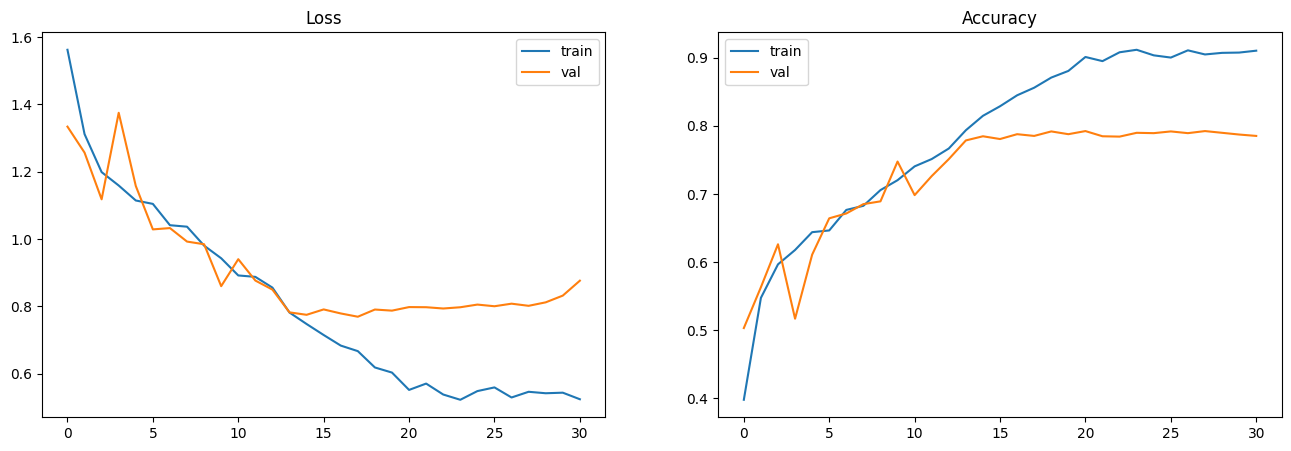

In [11]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val"); plt.title("Accuracy"); plt.legend()
plt.show()


TEST: loss 0.7813  acc 79.31%
              precision    recall  f1-score   support

       angry       0.84      0.83      0.84       503
     disgust       0.75      0.76      0.75       503
        fear       0.71      0.76      0.74       503
       happy       0.78      0.77      0.78       503
     neutral       0.82      0.86      0.84       517
         sad       0.79      0.69      0.73       503
    surprise       0.92      0.97      0.95       249

    accuracy                           0.79      3281
   macro avg       0.80      0.81      0.80      3281
weighted avg       0.79      0.79      0.79      3281



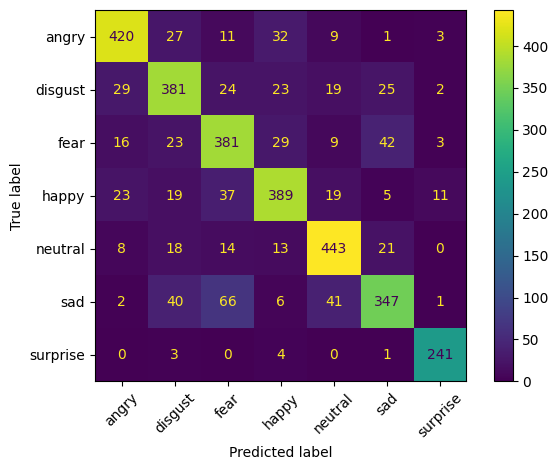

In [12]:
best_model = MelResNet(n_classes=len(classes), in_ch=3).to(device)
best_model.load_state_dict(torch.load(ckpt_path, map_location=device))
best_model.eval()

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
all_preds, all_true, loss_sum, total = [], [], 0.0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = best_model(xb)
        loss = criterion(logits, yb)
        loss_sum += loss.item() * yb.size(0)
        total += yb.size(0)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_true.append(yb.cpu().numpy())
y_pred = np.concatenate(all_preds); y_true = np.concatenate(all_true)
test_loss = loss_sum / total
test_acc = (y_pred == y_true).mean()
print(f"TEST: loss {test_loss:.4f}  acc {test_acc*100:.2f}%")

print(classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45); plt.tight_layout(); plt.show()


In [13]:
np.savez_compressed(
    f"mel_baseline_results_{SUFFIX}.npz",
    classes=np.array(classes, dtype=object),
    test_loss=float(test_loss),
    test_acc=float(test_acc),
    y_true=y_true,
    y_pred=y_pred,
)
print(f"Saved: mel_baseline_results_{SUFFIX}.npz")


Saved: mel_baseline_results_7cls.npz
